## Modules and data preparation

In [1]:
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import *
from sklearn.metrics import *
from sklearn.decomposition import PCA
from sklearn.preprocessing import Binarizer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [2]:
type_of_data = "spot"
tokens_pair = "btc_busd"
time_interval = "1h"
source = "binance"

load_path = "../data/original_features/%s/original_%s_%s_%s_%s.csv" % (type_of_data, type_of_data, source, tokens_pair, time_interval)
save_path = "../data/normalized_features/%s/norm_%s_%s_%s_%s.csv" % (type_of_data, type_of_data, source, tokens_pair, time_interval)

In [3]:
def figure_setup(fig_size: tuple=(16,9), dpi: int=90):
    sns.set()
    return plt.figure(figsize=fig_size, dpi=dpi)

fig = figure_setup()

<Figure size 1440x810 with 0 Axes>

In [4]:
from pandas import DataFrame

def data_normalization(df: DataFrame, days_range: int=24, include_cur_row: bool=True):
    '''
    Return the normalized data:
    + df: the dataframe to be normalized
    + range: the number of previous rows (or including the current row) to be considered in the normalization
    + include_cur_row: True if we consider the current row in the normalization process (calculate mean and std
    using the current row and (range-1) previous rows), False if we want to use all the passed data for normalization 
    processing ((calculate mean and std using (range) previous rows))
    '''
    
    df_roll = None

    if include_cur_row == False:
        df_roll = df.rolling(days_range, closed='left')
    else:
        df_roll = df.rolling(days_range)
        days_range -= 1
        
    res_df = (df - df_roll.mean()) / df_roll.std()
#     res_df.replace([np.inf, -np.inf, np.nan], 0, inplace=True)
    return res_df[days_range:]

In [5]:
original_df = pd.read_csv(load_path)
df = pd.read_csv(load_path)
periods = [2,4,8,12,24,48,96,192]

## Data preprocessing

In [6]:
df.drop(columns=["Unnamed: 0"], inplace=True)

In [7]:
long_period = 360
medium_period = 92
short_period = 24

### MA normalization

In [8]:
MAs = ["SMA", "WMA", "EMA", "HMA", "TEMA", "ALMA", "DEMA", "SMMA"]
price_types = ["open", "high", "low", "close"]

In [9]:
for price_type in price_types:
    for period in periods:
        for ma in MAs:
            col_name1 = price_type + "_" + ma + str(period)
            col_name2 = "cur_" + price_type + "_vs_" + col_name1
            
#             df[col_name2] = (df[price_type] - df[col_name1])/df[col_name1]
#             df[col_name1] = data_normalization(df[col_name1])

            # New
            df[col_name1] = np.log(df[price_type]/df[col_name1])

### Volume MA creation and normalization

In [10]:
volume_indicators = ["volume", "quote_asset_volume", "number_of_trades", "taker_buy_base_asset_volume", "taker_buy_quote_asset_volume"]

#### Volume MA creation

In [11]:
for volume_indicator in volume_indicators:
    for period in periods:
        df[volume_indicator+"_MA"+str(period)] = df[volume_indicator].rolling(period).mean()

/tmp/ipykernel_10321/24456842.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[volume_indicator+"_MA"+str(period)] = df[volume_indicator].rolling(period).mean()
/tmp/ipykernel_10321/24456842.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[volume_indicator+"_MA"+str(period)] = df[volume_indicator].rolling(period).mean()
/tmp/ipykernel_10321/24456842.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining 

#### Volume indicators normalization

In [12]:
volume_indicators = ["quote_asset_volume", "taker_buy_quote_asset_volume"]

In [13]:
for volume_indicator in volume_indicators:
#     df[volume_indicator] = np.log(df[volume_indicator]/(df[volume_indicator].shift(1))) 
#     df[volume_indicator].replace([-np.inf,np.inf], 0, inplace=True)
#     for period in periods:
#         col_name1 = volume_indicator + "_MA" + str(period)
#         df[col_name1] = np.log(df[col_name1]/df[col_name1].shift(1))

    # New
    df[volume_indicator] = data_normalization(df[volume_indicator], days_range=long_period)

In [14]:
# volume_dict_factor = {
#     4: 2,
#     8: 5,
#     12: 5,
#     16: 5,
#     20: 10,
#     24: 10,
#     36: 10,
#     48: 10,
#     72: 20,
#     96: 40
# }

In [15]:
# for volume_indicator in volume_indicators:
#     for period in periods:
#         df[volume_indicator+"_MA"+str(period)] *= volume_dict_factor[period]

In [16]:
# df.drop(columns=["volume_ts_y"], inplace=True)
# df.rename(columns={"volume_ts_x": "volume_ts"}, inplace=True)

### KAMA indicator

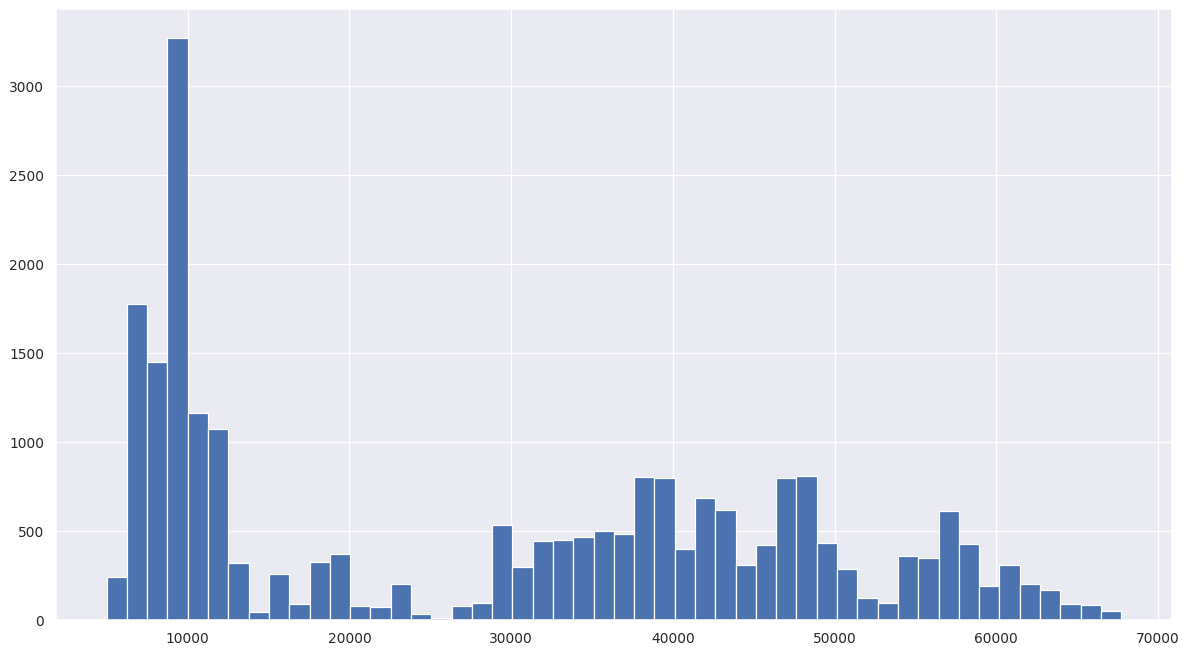

In [17]:
figure_setup()
plt.hist(df["KAMA"], bins=50);

In [18]:
col_name1 = "KAMA"
# col_name2 = "cur_close_vs_" + col_name1
# df[col_name2] = (df[price_type] - df[col_name1])/df[col_name1]
df[col_name1] = data_normalization(df[col_name1], days_range=short_period) 

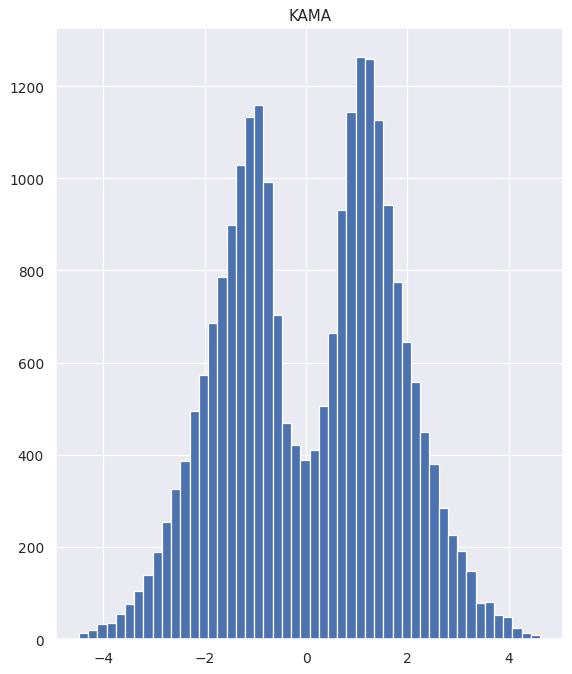

In [19]:
figure_setup()
plt.subplot(121)
plt.hist(df["KAMA"], bins=50)
plt.title("KAMA")
# plt.subplot(122)
# plt.hist(df["cur_close_vs_KAMA"], bins=50)
# plt.title("cur_close_vs_KAMA")
plt.show()

### KST Indicator
*Already normalized by its definition*

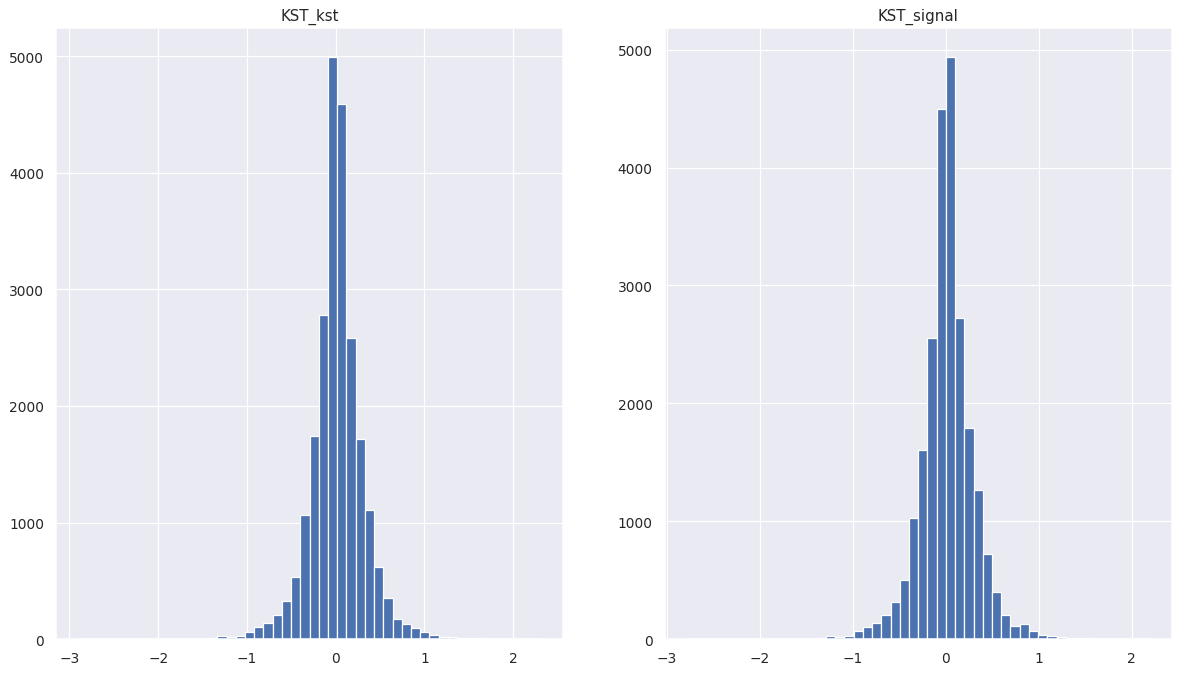

In [20]:
figure_setup()
plt.subplot(121)
df["KST_kst"] /= 100
plt.hist(df["KST_kst"], bins=50)
plt.title("KST_kst")
plt.subplot(122)
df["KST_signal"] /= 100
plt.hist(df["KST_signal"], bins=50)
plt.title("KST_signal")
plt.show()

### MACD Indicator
*Already normalized by its definition*

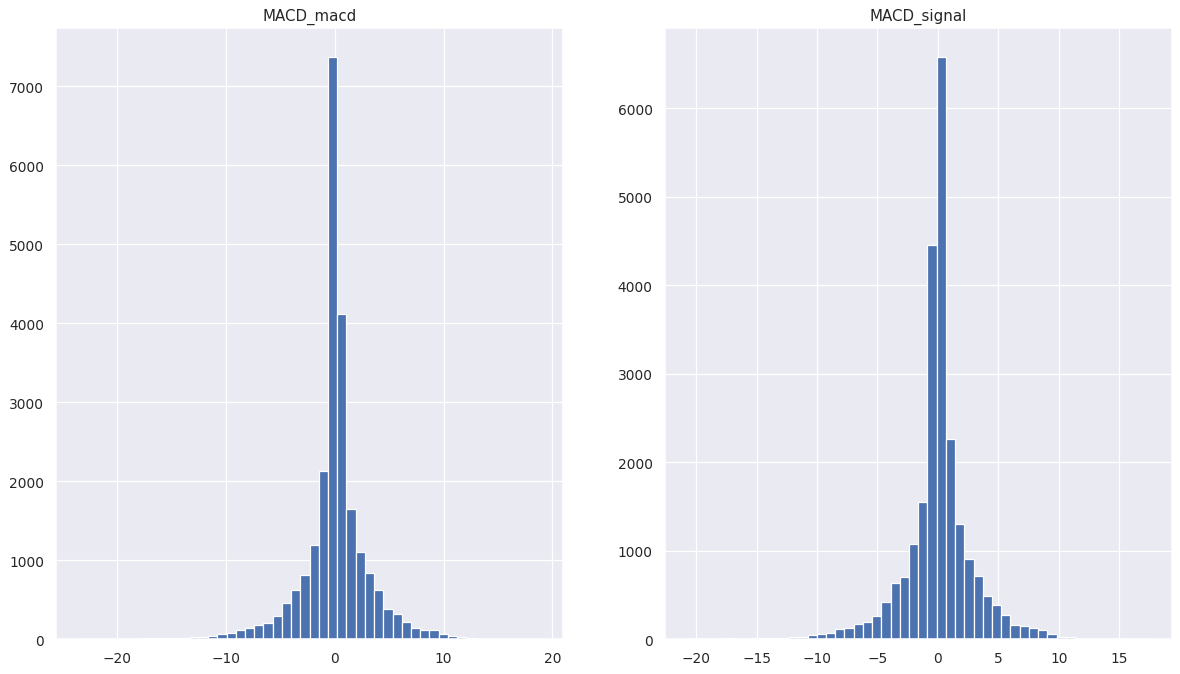

In [21]:
figure_setup()
plt.subplot(121)
df["MACD_macd"]/=100
plt.hist(df["MACD_macd"], bins=50)
plt.title("MACD_macd")
plt.subplot(122)
df["MACD_signal"] /= 100
plt.hist(df["MACD_signal"], bins=50)
plt.title("MACD_signal")
plt.show()

### Mass Index

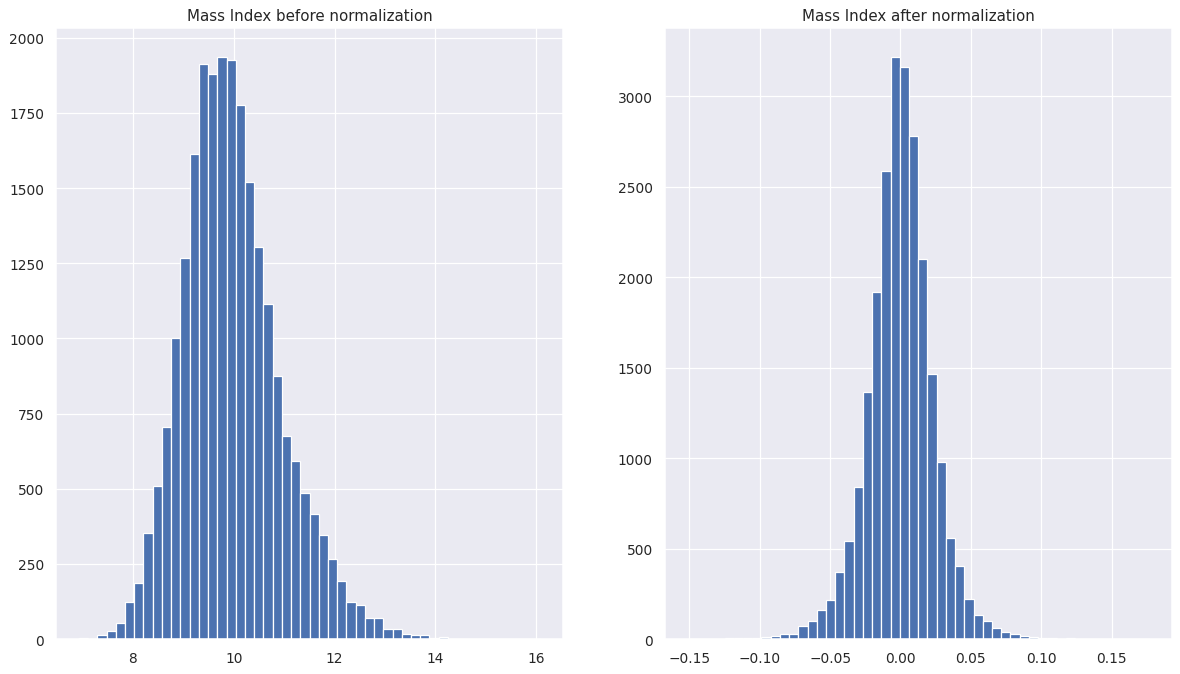

In [22]:
figure_setup()
plt.subplot(121)
plt.hist(df["MassIndex"], bins=50)
plt.title("Mass Index before normalization")
plt.subplot(122)
df["MassIndex"] = np.log(df["MassIndex"]/df["MassIndex"].shift(1))
plt.hist(df["MassIndex"], bins=50)
plt.title("Mass Index after normalization")
plt.show()

### OBV

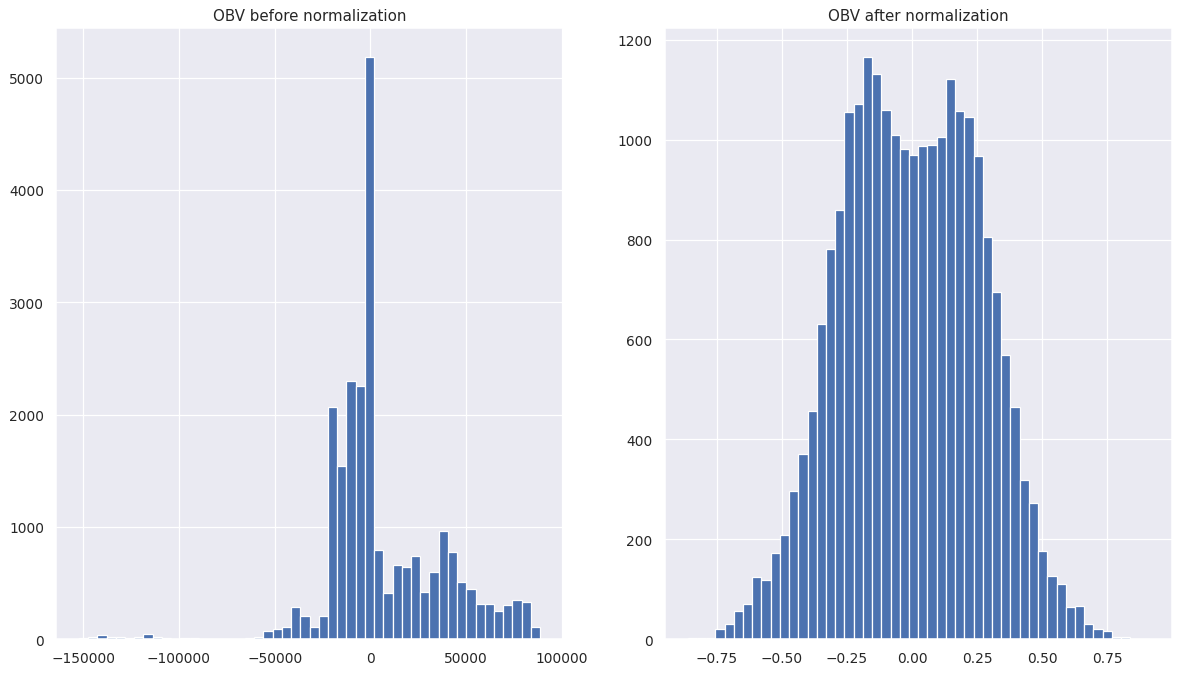

In [23]:
figure_setup()
plt.subplot(121)
plt.hist(df["OBV"], bins=50)
plt.title("OBV before normalization")
plt.subplot(122)
df["OBV"] = data_normalization(df["OBV"])/5
plt.hist(df["OBV"], bins=50)
plt.title("OBV after normalization")
plt.show()

### KVO

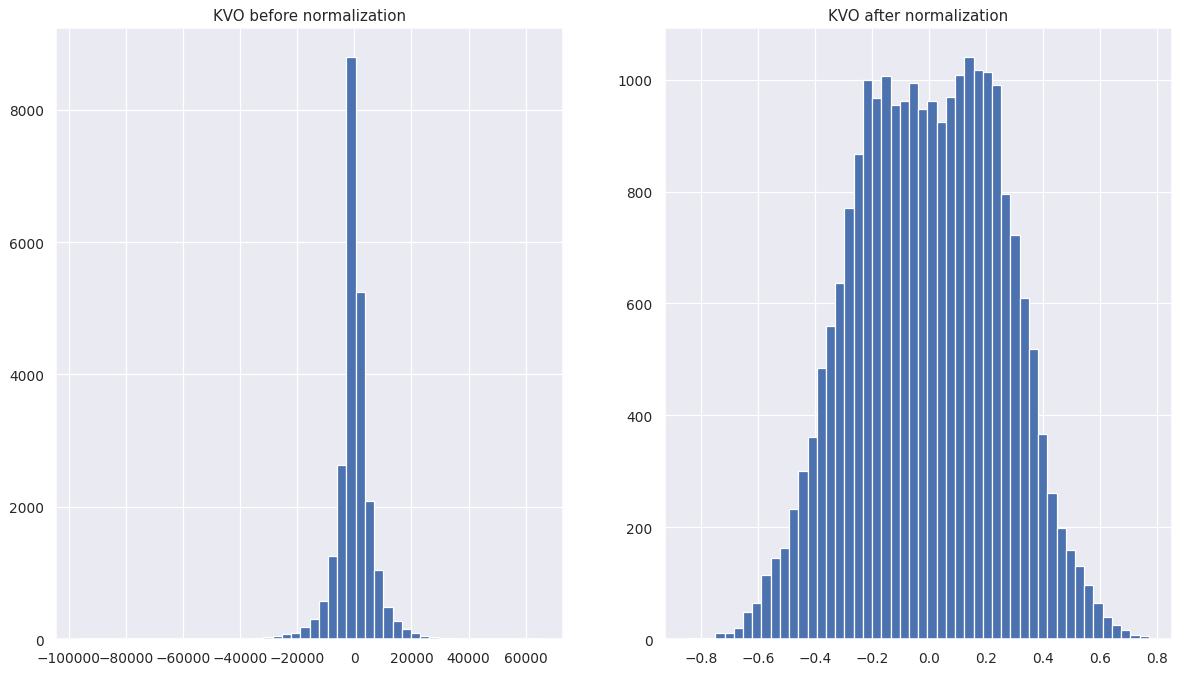

In [24]:
figure_setup()
plt.subplot(121)
plt.hist(df["KVO"], bins=50)
plt.title("KVO before normalization")
plt.subplot(122)
df["KVO"] = data_normalization(df["KVO"])/5
plt.hist(df["KVO"], bins=50)
plt.title("KVO after normalization")
plt.show()

### VWAP

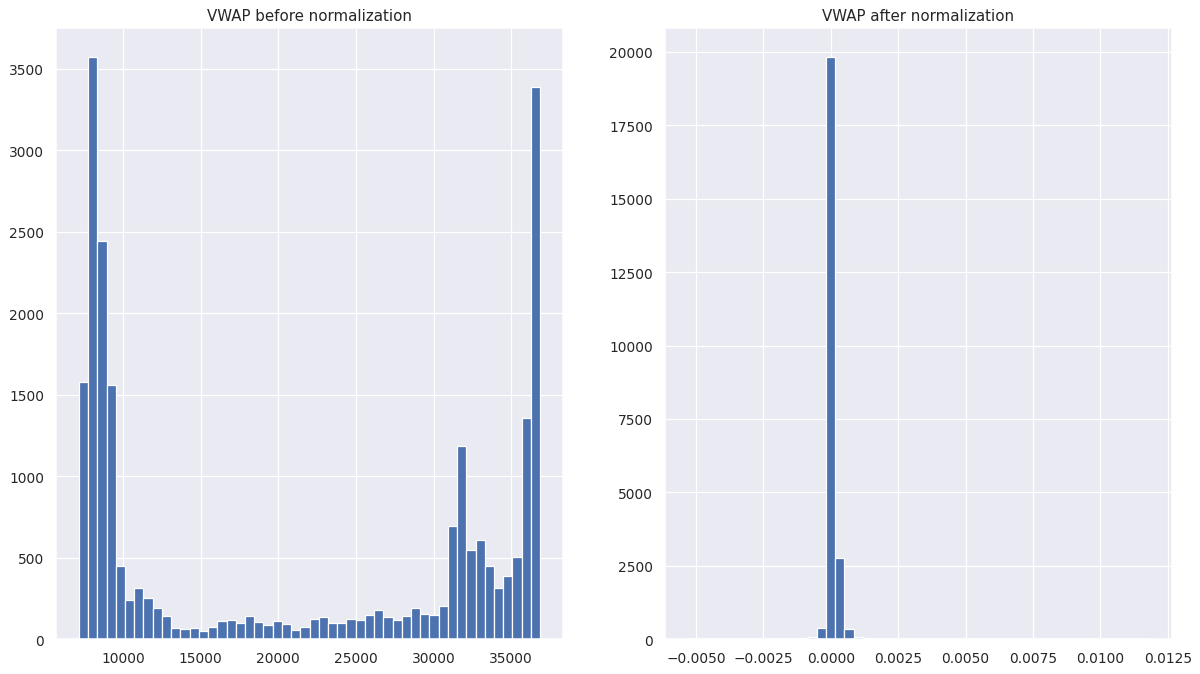

In [25]:
figure_setup()
plt.subplot(121)
plt.hist(df["VWAP"], bins=50)
plt.title("VWAP before normalization")
plt.subplot(122)
df["VWAP"] = np.log(df["VWAP"]/df["VWAP"].shift(1))
plt.hist(df["VWAP"], bins=50)
plt.title("VWAP after normalization")
plt.show()

### AccuDist

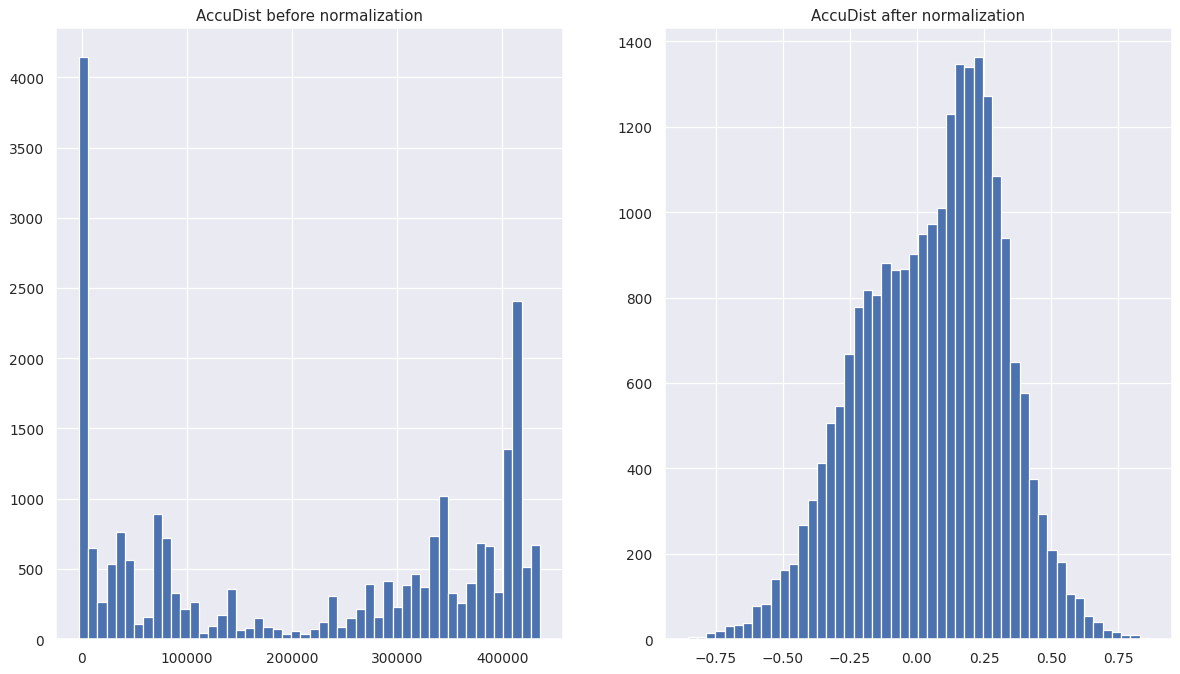

In [26]:
figure_setup()
plt.subplot(121)
plt.hist(df["AccuDist"], bins=50)
plt.title("AccuDist before normalization")
plt.subplot(122)
df["AccuDist"] = data_normalization(df["AccuDist"])/5
plt.hist(df["AccuDist"], bins=50)
plt.title("AccuDist after normalization")
plt.show()

### BOP
*Already normalized by its definition*

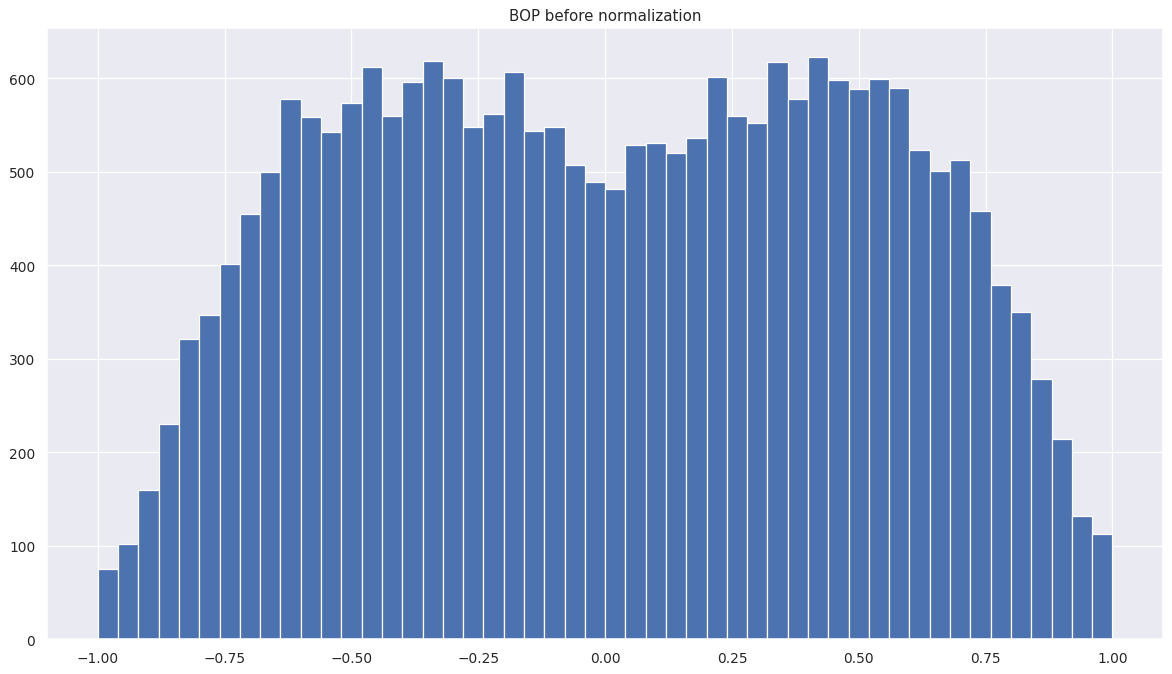

In [27]:
figure_setup()
plt.hist(df["BOP"], bins=50)
plt.title("BOP before normalization")
plt.show()

### UO
*Already normalized by its definition but not in standard normal distribution*

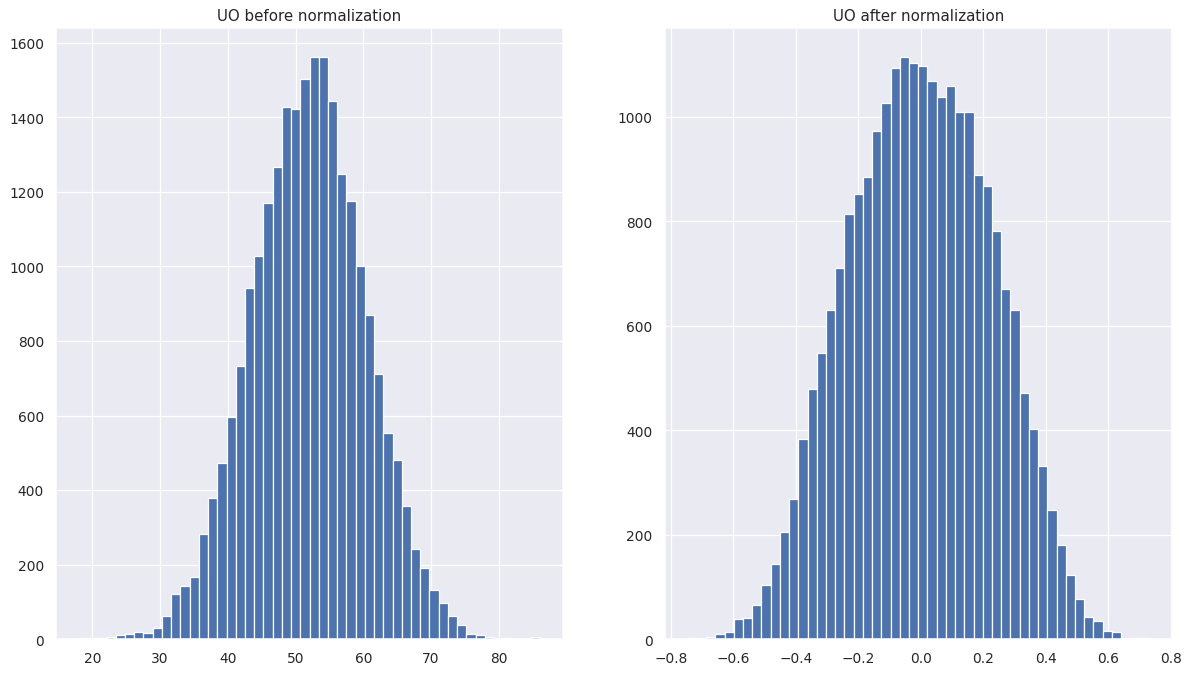

In [28]:
figure_setup()
plt.subplot(121)
plt.hist(df["UO"], bins=50)
plt.title("UO before normalization")
plt.subplot(122)
df["UO"] = data_normalization(df["UO"])/5
plt.hist(df["UO"], bins=50)
plt.title("UO after normalization")
plt.show()

### TSI
*Already normalized by its definition*

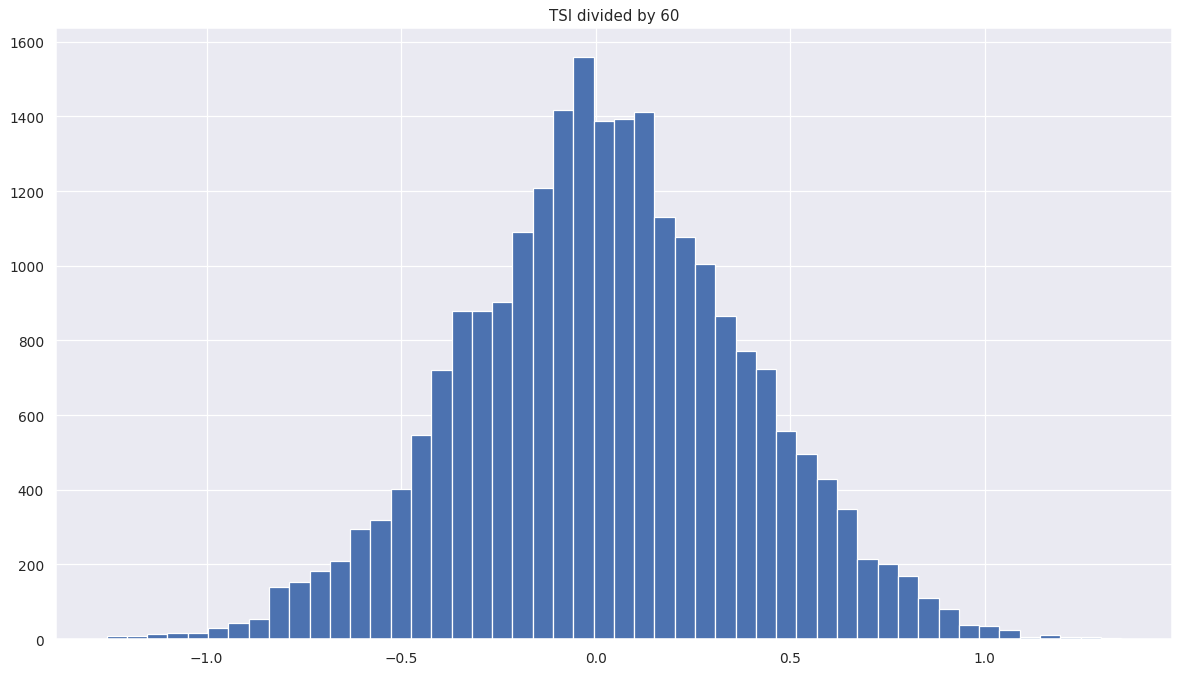

In [29]:
figure_setup()
df["TSI"] /= 60
plt.hist(df["TSI"], bins=50)
plt.title("TSI divided by 60")
plt.show()

### AO
*Already normalized by its definition*

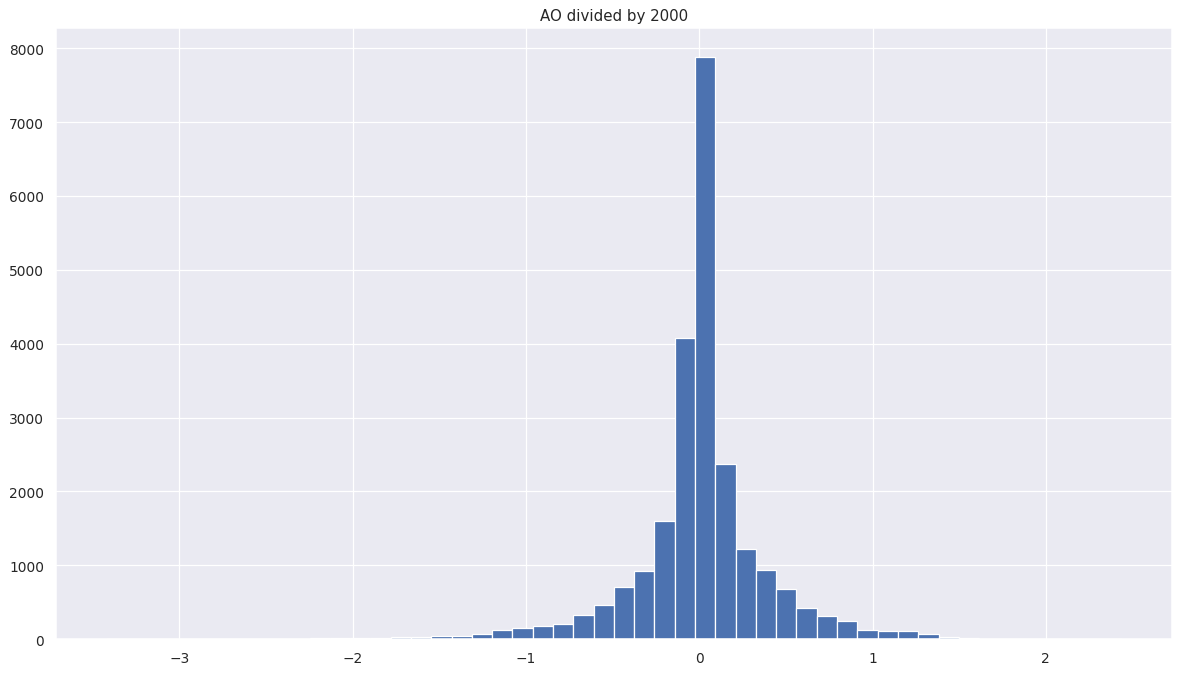

In [30]:
figure_setup()
df["AO"] /= 2000
plt.hist(df["AO"], bins=50)
plt.title("AO divided by 2000")
plt.show()

### CCI

In [31]:
# cci_factor = {
#     4: 125,
#     8: 200,
#     12: 250,
#     16: 250,
#     20: 200,
#     24: 200,
#     36: 200,
#     48: 300,
#     72: 350,
#     96: 350
# }

In [32]:
# i = 0
# fig = figure_setup()
# fig.subplots_adjust(hspace=1)

# while i < 10:
#     fig.add_subplot(5, 2, i+1)
#     df["CCI"+str(periods[i])] /= cci_factor[periods[i]]
#     plt.hist(df["CCI"+str(periods[i])] , bins=50)
#     plt.title("CCI%s divided by %d"%(str(periods[i]), cci_factor[periods[i]]))
#     i += 1

# plt.show()

In [33]:
for period in periods:
    df["CCI"+str(period)]/=100

### CHOP

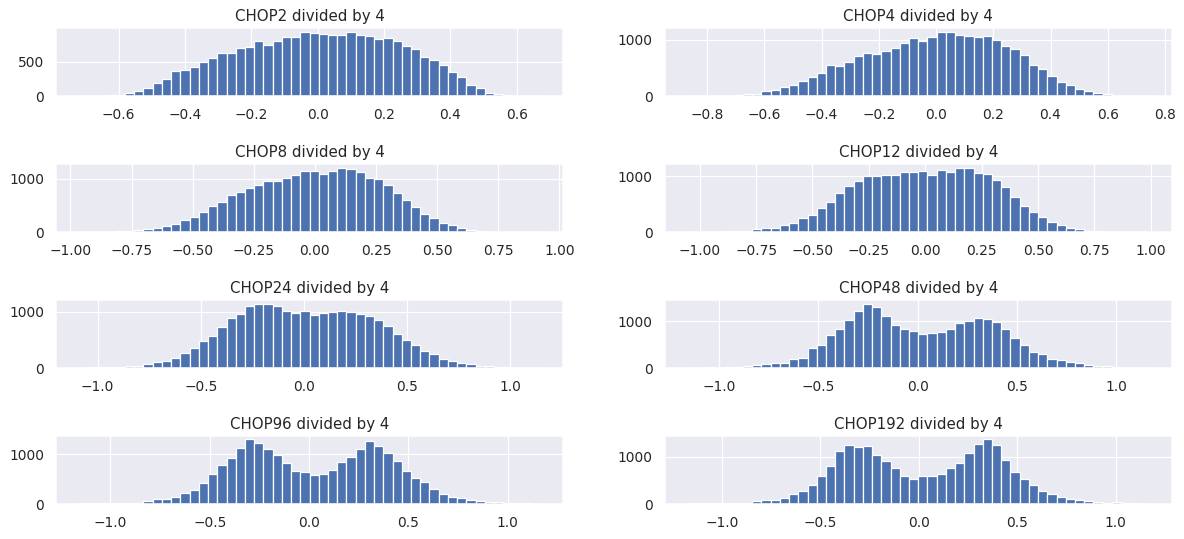

In [34]:
i = 0
fig = figure_setup()
fig.subplots_adjust(hspace=1)

while i < 8:
    fig.add_subplot(5, 2, i+1)
    df["CHOP"+str(periods[i])] = data_normalization(df["CHOP"+str(periods[i])])/4
    plt.hist(df["CHOP"+str(periods[i])] , bins=50)
    plt.title("CHOP%s divided by 4"%(str(periods[i])))
    i += 1

plt.show()

### VTX

In [35]:
for period in periods:
    df["VTX"+str(period)+"_minus_vtx"] -= 1
    df["VTX"+str(period)+"_plus_vtx"] -= 1

### SOBV

In [36]:
for period in periods:
    if period >= 16:
        df["SOBV"+str(period)] = data_normalization(df["SOBV"+str(period)])/5
    df["SOBV"+str(period)] = data_normalization(df["SOBV"+str(period)])/4

### ATR

In [37]:
for period in periods:
    df["ATR"+str(period)] = df["ATR"+str(period)]/original_df["close_SMA"+str(period)]

### Force Index

In [38]:
force_index_factor = {
    2: 1e6,
    4: 7e5,
    8: 5.5e5,
    12: 4.5e5,
    24: 4.5e5,
    48: 4e5,
    96: 3e5,
    192: 2.8e5
}


In [39]:
for period in periods:
#     df["ForceIndex"+str(period)] /= force_index_factor[period]
    df["ForceIndex"+str(period)] /= 1e6

### MeanDev and StdDev

In [40]:
for period in periods:
    for price_type in price_types:
        df[price_type+"_MeanDev%d_over_StdDev%d"%(period,period)] = data_normalization(df[price_type+"_MeanDev"+str(period)]/df[price_type+"_StdDev"+str(period)])
        df[price_type+"_StdDev"+str(period)] = data_normalization(df[price_type+"_StdDev"+str(period)])
        df[price_type+"_MeanDev"+str(period)] = data_normalization(df[price_type+"_MeanDev"+str(period)])

/tmp/ipykernel_10321/3128639797.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[price_type+"_MeanDev%d_over_StdDev%d"%(period,period)] = data_normalization(df[price_type+"_MeanDev"+str(period)]/df[price_type+"_StdDev"+str(period)])
/tmp/ipykernel_10321/3128639797.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[price_type+"_MeanDev%d_over_StdDev%d"%(period,period)] = data_normalization(df[price_type+"_MeanDev"+str(period)]/df[price_type+"_StdDev"+str(period)])
/tmp/ipykernel_10321/3128639797.py:3: PerformanceWarning

/tmp/ipykernel_10321/3128639797.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[price_type+"_MeanDev%d_over_StdDev%d"%(period,period)] = data_normalization(df[price_type+"_MeanDev"+str(period)]/df[price_type+"_StdDev"+str(period)])
/tmp/ipykernel_10321/3128639797.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[price_type+"_MeanDev%d_over_StdDev%d"%(period,period)] = data_normalization(df[price_type+"_MeanDev"+str(period)]/df[price_type+"_StdDev"+str(period)])
/tmp/ipykernel_10321/3128639797.py:3: PerformanceWarning

### RSI

In [41]:
for period in periods:
    for price_type in price_types:
        df[price_type+"_RSI"+str(period)] /= 100

### ROC

In [42]:
roc_divisor = {
    4: 1.6,
    8: 2.3,
    12: 2.8,
    16: 3.2,
    20: 3.7,
    24: 4.1,
    36: 4.8,
    48: 5.6,
    72: 6.9,
    96: 7.9
}

In [43]:
# fig = figure_setup()
# fig.subplots_adjust(hspace=1)

# for price_type in price_types:
#     i = 0
#     while i < 10:
#         df[price_type+"_ROC"+str(periods[i])] /= roc_divisor[periods[i]]
#         if price_type == 'close':
#             fig.add_subplot(5, 2, i+1)
#             plt.hist(df[price_type+"_ROC"+str(periods[i])] , bins=50)
#             plt.title(price_type+"_ROC%s divided by %f"%(str(periods[i]), roc_divisor[periods[i]]))
#         i += 1

# plt.show()

### DPO

In [44]:
dpo_divisor = {
    2: 200,
    4: 210,
    8: 240,
    12: 265,
    24: 285,
    48: 310,
    96: 380,
    192: 440
}

In [45]:
# for price_type in price_types:
#     i = 0
#     while i < 10:
#         df[price_type+"_DPO"+str(periods[i])] = df[price_type+"_DPO"+str(periods[i])].copy()
#         i += 1

In [46]:
# fig = figure_setup()
# fig.subplots_adjust(hspace=1)

# for price_type in price_types:
#     i = 0
#     while i < 10:
#         df[price_type+"_DPO"+str(periods[i])] /= dpo_divisor[periods[i]]
#         print(price_type+"_DPO"+str(periods[i]))
#         print(df[price_type+"_DPO"+str(periods[i])].mean())
#         print(df[price_type+"_DPO"+str(periods[i])].std())
#         print("\n\n")
#         if price_type == 'close':
#             fig.add_subplot(5, 2, i+1)
#             plt.hist(df[price_type+"_DPO"+str(periods[i])] , bins=50)
#             plt.title(price_type+"_DPO%s divided by %f"%(str(periods[i]), dpo_divisor[periods[i]]))
#         i += 1

# plt.show()

In [47]:
for price_type in price_types:
    for period in periods:
        df[price_type+"_DPO"+str(period)] /= 1000

### TRIX

In [48]:
trix_divisor = {
    2: 100,
    4: 50,
    8: 50,
    12: 50,
    24: 40,
    48: 40,
    96: 20,
    192: 20
}


In [49]:
for price_type in price_types:
    for period in periods:
#         df[price_type+"_TRIX"+str(period)] /= trix_divisor[period]
        df[price_type+"_TRIX"+str(period)] /= 50

### CoppockCurve

In [50]:
df["CoppockCurve"] /= 20

### ADX

In [51]:
df["ADX_adx"] = data_normalization(df["ADX_adx"])
df["ADX_plus_di"] = data_normalization(df["ADX_plus_di"])
df["ADX_minus_di"] = data_normalization(df["ADX_minus_di"])

### OHLC

In [52]:
for price_type in price_types:
#     df[price_type] = (df[price_type] - df[price_type].shift(1))/df[price_type].shift(1)
    df[price_type] = np.log(df[price_type]/df[price_type].shift(1))
    for k in ["max", "min", "median"]:
        for period in periods:
            df[price_type+"_"+k+str(period)] = np.log(df[price_type+"_"+k+str(period)])/df[price_type+"_"+k+str(period)].shift(1)

In [53]:
for c in df.columns:
    print(c)

open_time
open
high
low
close
volume
quote_asset_volume
number_of_trades
taker_buy_base_asset_volume
taker_buy_quote_asset_volume
CoppockCurve
KAMA
KST_kst
KST_signal
MACD_macd
MACD_signal
MassIndex
OBV
KVO
VWAP
AccuDist
BOP
UO
TSI
AO
CCI2
CHOP2
VTX2_plus_vtx
VTX2_minus_vtx
SOBV2
ATR2
ForceIndex2
ADX_plus_di
ADX_minus_di
ADX_adx
open_max2
open_min2
open_median2
open_SMA2
open_SMMA2
open_WMA2
open_ALMA2
open_TEMA2
open_EMA2
open_DEMA2
open_DPO2
open_HMA2
open_MeanDev2
open_StdDev2
open_RSI2
open_ROC2
open_TRIX2
close_max2
close_min2
close_median2
close_SMA2
close_SMMA2
close_WMA2
close_ALMA2
close_TEMA2
close_EMA2
close_DEMA2
close_DPO2
close_HMA2
close_MeanDev2
close_StdDev2
close_RSI2
close_ROC2
close_TRIX2
high_max2
high_min2
high_median2
high_SMA2
high_SMMA2
high_WMA2
high_ALMA2
high_TEMA2
high_EMA2
high_DEMA2
high_DPO2
high_HMA2
high_MeanDev2
high_StdDev2
high_RSI2
high_ROC2
high_TRIX2
low_max2
low_min2
low_median2
low_SMA2
low_SMMA2
low_WMA2
low_ALMA2
low_TEMA2
low_EMA2
low_DEMA2


In [54]:
df.ffill(inplace=True)
df.dropna(inplace=True)
df

,open_time,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,...,low_MeanDev48_over_StdDev48,close_MeanDev48_over_StdDev48,open_MeanDev96_over_StdDev96,high_MeanDev96_over_StdDev96,low_MeanDev96_over_StdDev96,close_MeanDev96_over_StdDev96,open_MeanDev192_over_StdDev192,high_MeanDev192_over_StdDev192,low_MeanDev192_over_StdDev192,close_MeanDev192_over_StdDev192
545,1572915600000,-0.002229,0.005938,0.001995,0.006342,47.272060,0.901608,692.0,30.339380,1.434184,...,-1.636029,-1.904367,-1.397085,-1.988723,-1.998195,-1.397085,1.806859,3.064490,3.423941,1.806859
546,1572919200000,0.005531,-0.000161,0.003555,0.000399,36.854428,0.515823,708.0,18.720350,0.594464,...,-1.990306,-1.977549,-1.577357,-1.885464,-2.297950,-1.577357,3.142044,3.228206,3.672481,3.142044
547,1572922800000,0.000521,-0.002203,-0.001638,-0.002613,21.477954,-0.054381,451.0,7.300988,-0.233823,...,-2.030560,-1.963665,-1.829309,-1.550083,-1.965179,-1.829309,3.508715,3.102982,3.331817,3.508715
548,1572926400000,-0.002509,-0.002509,-0.003629,-0.003231,25.990785,0.107585,407.0,5.745960,-0.348503,...,-1.615396,-1.786472,-1.358720,-1.091216,-1.453892,-1.358720,3.091525,2.713717,2.906165,3.091525
549,1572930000000,-0.003231,-0.001026,0.000649,0.000301,14.838560,-0.303083,674.0,6.598447,-0.286794,...,-1.128234,-1.345239,-0.793909,-0.749300,-1.129885,-0.793909,2.858092,2.561975,2.850369,2.858092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23590,1655877600000,-0.003076,-0.007333,-0.021624,-0.012863,2518.593620,0.164186,40558.0,1200.300370,0.095291,...,0.501466,1.033182,-0.480011,0.522384,-1.596256,-0.480011,-2.171116,-1.843530,-2.018478,-2.171116
23591,1655881200000,-0.012776,-0.009495,0.001354,-0.000555,1580.539830,-0.441455,31494.0,783.034520,-0.459575,...,0.624955,0.964614,-1.378447,-0.713403,-2.295419,-1.378447,-1.958188,-1.678666,-1.883375,-1.958188
23592,1655884800000,-0.000642,0.000420,0.004218,0.006750,996.480580,-0.814509,21997.0,518.048830,-0.807116,...,0.612945,0.931888,-2.435904,-2.202551,-2.781003,-2.435904,-1.704041,-1.572964,-1.722671,-1.704041
23593,1655888400000,0.006750,0.011720,0.009135,0.009489,2338.224590,0.059715,30810.0,1279.579980,0.211568,...,1.112992,1.261552,-3.022235,-2.858306,-2.838026,-3.022235,-1.628019,-1.633379,-1.747551,-1.628019


In [55]:
df.to_csv(save_path)